In [45]:
import geopandas as gpd

from pystac_client import Client  
from pystac_client import ItemSearch
from pystac.item import Item
from shapely.geometry import box, shape
import yaml
from rasterio.crs import CRS
import datetime
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import rasterio
from rasterio.merge import merge
import numpy as np
import asf_search as asf
from dem_stitcher.rio_tools import reproject_arr_to_new_crs, reproject_arr_to_match_profile
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [2]:
yaml_file = 'events/jebel_ali_flood_2024.yml' #'porto_algre.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'jebel_ali_flood',
 'bounds': [54.5, 23.5, 56.5, 25.5],
 'event_date': '2024-04-16',
 'pre_event_window_days': 30,
 'post_event_window_days': 30,
 'links': ['https://www.cnn.com/2024/04/22/weather/dubai-flooding-before-after-satellite-climate/index.html']}

In [3]:
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])

In [4]:
aoi = box(*event_dict['bounds'])
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [5]:
#df_mgrs = gpd.read_file('https://raw.githubusercontent.com/NASA-IMPACT/hls-land_tiles/master/s2_grid.json')

In [6]:
stac = 'https://cmr.earthdata.nasa.gov/cloudstac/'    # CMR-STAC API Endpoint
api = Client.open(f'{stac}/POCLOUD/')
collections = ['OPERA_L3_DSWX-HLS_V1']

search_params = {"collections": collections,
                 "intersects": aoi.__geo_interface__,
                 "datetime": [PRE_DT_START, POST_DT_STOP],
                 "max_items": 1000}
search_dswx = api.search(**search_params)

In [7]:
l = list(search_dswx.items())
len(l)

429

In [8]:
def format_item(item):
    out = {**{'id': item.id}, 
           **item.properties, 
           **{'geometry': shape(item.geometry)},
           **{key: value.href for (key, value) in sorted(item.assets.items())[:2]}
          }
    return out
    

In [9]:
data = list(map(format_item, l))
df_resp = pd.DataFrame(data)
df_resp = gpd.GeoDataFrame(df_resp, geometry=df_resp.geometry, crs=CRS.from_epsg(4326))
df_resp['datetime'] = pd.to_datetime(df_resp['datetime'])
df_resp['acq_date']= df_resp['datetime'].dt.date
df_resp['sensor'] = df_resp['id'].map(lambda oid: oid.split('_')[-3]) 
df_resp.head()

,id,eo:cloud_cover,datetime,start_datetime,end_datetime,geometry,0_B01_WTR,0_B02_BWTR,acq_date,sensor
0,OPERA_L3_DSWx-HLS_T40RBP_20240317T065209Z_2024...,6.0,2024-03-17 06:52:09.423000+00:00,2024-03-17T06:52:09.423Z,2024-03-17T06:52:09.423Z,"POLYGON ((53.94800 25.24100, 55.06300 25.24100...",https://archive.podaac.earthdata.nasa.gov/poda...,https://archive.podaac.earthdata.nasa.gov/poda...,2024-03-17,L8
1,OPERA_L3_DSWx-HLS_T40RBN_20240317T065209Z_2024...,12.0,2024-03-17 06:52:09.423000+00:00,2024-03-17T06:52:09.423Z,2024-03-17T06:52:09.423Z,"POLYGON ((53.97100 24.33900, 55.07700 24.33900...",https://archive.podaac.earthdata.nasa.gov/poda...,https://archive.podaac.earthdata.nasa.gov/poda...,2024-03-17,L8
2,OPERA_L3_DSWx-HLS_T39RZH_20240317T065209Z_2024...,12.0,2024-03-17 06:52:09.423000+00:00,2024-03-17T06:52:09.423Z,2024-03-17T06:52:09.423Z,"POLYGON ((53.90800 24.31700, 55.02000 24.31700...",https://archive.podaac.earthdata.nasa.gov/poda...,https://archive.podaac.earthdata.nasa.gov/poda...,2024-03-17,L8
3,OPERA_L3_DSWx-HLS_T39RZJ_20240317T065209Z_2024...,6.0,2024-03-17 06:52:09.423000+00:00,2024-03-17T06:52:09.423Z,2024-03-17T06:52:09.423Z,"POLYGON ((53.92900 25.21800, 55.05100 25.21800...",https://archive.podaac.earthdata.nasa.gov/poda...,https://archive.podaac.earthdata.nasa.gov/poda...,2024-03-17,L8
4,OPERA_L3_DSWx-HLS_T40QBM_20240317T065233Z_2024...,7.0,2024-03-17 06:52:33.314000+00:00,2024-03-17T06:52:33.314Z,2024-03-17T06:52:33.314Z,"POLYGON ((53.99300 23.43700, 55.09000 23.43700...",https://archive.podaac.earthdata.nasa.gov/poda...,https://archive.podaac.earthdata.nasa.gov/poda...,2024-03-17,L8


<Axes: >

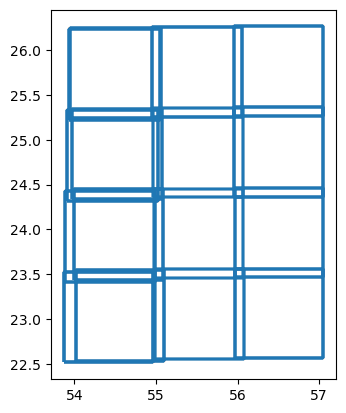

In [10]:
df_resp.exterior.plot()

In [11]:
df_resp.acq_date.unique()

array([datetime.date(2024, 3, 17), datetime.date(2024, 3, 18),
       datetime.date(2024, 3, 19), datetime.date(2024, 3, 20),
       datetime.date(2024, 3, 21), datetime.date(2024, 3, 23),
       datetime.date(2024, 3, 25), datetime.date(2024, 3, 26),
       datetime.date(2024, 3, 28), datetime.date(2024, 3, 30),
       datetime.date(2024, 4, 2), datetime.date(2024, 4, 4),
       datetime.date(2024, 4, 5), datetime.date(2024, 4, 7),
       datetime.date(2024, 4, 9), datetime.date(2024, 4, 10),
       datetime.date(2024, 4, 11), datetime.date(2024, 4, 12),
       datetime.date(2024, 4, 13), datetime.date(2024, 4, 14),
       datetime.date(2024, 4, 15), datetime.date(2024, 4, 17),
       datetime.date(2024, 4, 18), datetime.date(2024, 4, 19),
       datetime.date(2024, 4, 20), datetime.date(2024, 4, 22),
       datetime.date(2024, 4, 25), datetime.date(2024, 4, 27),
       datetime.date(2024, 4, 29), datetime.date(2024, 4, 30),
       datetime.date(2024, 5, 4), datetime.date(2024, 5, 5),

In [12]:
dswx_hls_dir = Path('out') / event_dict['event_name'] / 'dswx_hls'
dswx_hls_dir.mkdir(exist_ok=True, parents=True)

In [19]:
%%time

for (sensor, date), df_rtc_date in tqdm(df_resp.groupby(['sensor', 'acq_date']), desc='dates'):
    wtr_links = df_rtc_date['0_B01_WTR']
    
    date_dir = dswx_hls_dir / f'{str(date)}__{sensor}'
    date_dir.mkdir(exist_ok=True, parents=True)

    asf.download_urls(urls=wtr_links, path=date_dir, processes=5)

dates:   0%|                  | 0/48 [00:00<?, ?it/s]/Users/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/asf_search/download/download.py:68: UserWarning: File already exists, skipping download: out/jebel_ali_flood/dswx_hls/2024-03-17__L8/OPERA_L3_DSWx-HLS_T39RZH_20240317T065209Z_20240319T085427Z_L8_30_v1.0_B01_WTR.tif
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')
/Users/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/asf_search/download/download.py:68: UserWarning: File already exists, skipping download: out/jebel_ali_flood/dswx_hls/2024-03-17__L8/OPERA_L3_DSWx-HLS_T39QZG_20240317T065233Z_20240319T085355Z_L8_30_v1.0_B01_WTR.tif
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')
/Users/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/asf_search/download/download.py:68: UserWarning: File already exists, skipping download: out/jebel_ali_flood/dswx_hls/2024-03-17

CPU times: user 210 ms, sys: 794 ms, total: 1 s
Wall time: 17.1 s


# Merge

In [20]:
all_acq_dirs = sorted([acq_dir for acq_dir in dswx_hls_dir.glob('*')])
all_acq_dirs = list(filter(lambda p: p.is_dir(), all_acq_dirs))
all_acq_dirs

[PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-17__L8'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-18__S2A'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-19__L8'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-20__S2B'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-21__S2A'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-23__S2B'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-24__L8'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-25__S2A'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-26__L8'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-26__S2B'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-28__L8'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-28__S2A'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-30__S2B'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-04-02__L8'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-04-02__S2B'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-04-04__L8'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-0

In [81]:
import concurrent.futures
import warnings
from typing import Union

import numpy as np
import rasterio
from rasterio.crs import CRS
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.merge import merge
from rasterio.windows import Window
from shapely.geometry import box
from tqdm import tqdm

def merge_arrays_with_geometadata(
    arrays: list[np.ndarray],
    profiles: list[dict],
    resampling='bilinear',
    nodata = None,
    dtype: str = None,
    method='first',
) -> tuple[np.ndarray, dict]:
    n_dim = arrays[0].shape
    if len(n_dim) not in [2, 3]:
        raise ValueError('Currently arrays must be in BIP format' 'i.e. channels x height x width or flat array')
    if len(set([len(arr.shape) for arr in arrays])) != 1:
        raise ValueError('All arrays must have same number of dimensions i.e. 2 or 3')

    if len(n_dim) == 2:
        arrays_input = [arr[np.newaxis, ...] for arr in arrays]
    else:
        arrays_input = arrays

    if (len(arrays)) != (len(profiles)):
        raise ValueError('Length of arrays and profiles needs to be the same')

    memfiles = [MemoryFile() for p in profiles]
    datasets = [mfile.open(**p) for (mfile, p) in zip(memfiles, profiles)]
    [ds.write(arr) for (ds, arr) in zip(datasets, arrays_input)]

    if dtype is None:
        dst_dtype = profiles[0]['dtype']
    if nodata is None:
        dst_nodata = profiles[0]['nodata']

    merged_arr, merged_trans = merge(
        datasets, resampling=Resampling[resampling], method='min', nodata=dst_nodata, dtype=dst_dtype
    )

    prof_merged = profiles[0].copy()
    prof_merged['transform'] = merged_trans
    prof_merged['count'] = merged_arr.shape[0]
    prof_merged['height'] = merged_arr.shape[1]
    prof_merged['width'] = merged_arr.shape[2]
    prof_merged['nodata'] = dst_nodata
    prof_merged['dtype'] = dst_dtype
    
    [ds.close() for ds in datasets]
    [mfile.close() for mfile in memfiles]

    return merged_arr, prof_merged

In [85]:
#from dem_stitcher.merge import merge_arrays_with_geometadata

def get_crs(path: str) -> Path:
    with rasterio.open(path) as ds:
        crs = ds.crs
    return crs

def get_profile(path: Path) -> dict:
    with rasterio.open(path) as ds:
        p = ds.profile
    return p


def read_one(path: Path) -> tuple:
    with rasterio.open(path) as ds:
        p = ds.profile
        X = ds.read()
    return X, p

def merge_one_dir(acq_dir: Path) -> list:
    all_img_paths = sorted(list(acq_dir.glob(f'OPERA*.tif')))
    crs_l = list(map(get_crs, all_img_paths))

    
    stem = acq_dir.stem
    dst_path = acq_dir / f'__{stem}_merged.tif'
    if len(list(set(crs_l))) == 1:
        merge(all_img_paths, dtype='uint8', method='min', dst_path=dst_path)
    else:
        profiles = list(map(get_profile, all_img_paths))
        ref_crs = crs_l[0]
        ref_profile = profiles[0]

        with rasterio.open(all_img_paths[0]) as ds:
            cmap = ds.colormap(1)
        zipped_data = [read_one(path) for path in all_img_paths]
        zipped_data = [(X, p) if p['crs'] == ref_crs 
                       else reproject_arr_to_new_crs(X, 
                                                     p, 
                                                     ref_crs, 
                                                     resampling='nearest') 
                       for (X, p) in zipped_data ]
        arrays, profiles_dst = zip(*zipped_data)
        arrays = [arr[0, ...] for arr in arrays]
        X_m, p_m = merge_arrays_with_geometadata(arrays, 
                                                 profiles_dst, 
                                                 resampling='nearest',
                                                 method='first')
        with rasterio.open(dst_path, 'w', **p_m) as ds:
            ds.write(X_m)
            ds.write_colormap(1, cmap)
    return dst_path

In [86]:
list(enumerate(all_acq_dirs))

[(0, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-17__L8')),
 (1, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-18__S2A')),
 (2, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-19__L8')),
 (3, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-20__S2B')),
 (4, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-21__S2A')),
 (5, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-23__S2B')),
 (6, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-24__L8')),
 (7, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-25__S2A')),
 (8, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-26__L8')),
 (9, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-26__S2B')),
 (10, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-28__L8')),
 (11, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-28__S2A')),
 (12, PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-30__S2B')),
 (13, PosixPath('out/jebel_ali_flood/dswx_hls/2024-04-02__L8')),
 (14, PosixPath('out/jebel_ali_flood/dswx_hls/2024-04-02__S2B')),
 (15, PosixPath('out/jebel

In [88]:
merge_one_dir(all_acq_dirs[21])

255.0 uint8
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10796, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


PosixPath('out/jebel_ali_flood/dswx_hls/2024-04-11__L8/__2024-04-11__L8_merged.tif')

In [89]:
dst_paths = [merge_one_dir(acq_dir) for acq_dir in tqdm(all_acq_dirs)]
dst_paths

  0%|                                                                                                                                   | 0/51 [00:00<?, ?it/s]

255.0 uint8


  2%|██▍                                                                                                                        | 1/51 [00:02<02:00,  2.41s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 7574, 'height': 13829, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2905114.3998004096), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


  4%|████▊                                                                                                                      | 2/51 [00:08<03:31,  4.32s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10933, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


  6%|███████▏                                                                                                                   | 3/51 [00:08<02:08,  2.68s/it]

255.0 uint8


 10%|████████████                                                                                                               | 5/51 [00:11<01:30,  1.96s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10488, 'height': 13984, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2909756.665607162), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 12%|██████████████▍                                                                                                            | 6/51 [00:12<01:15,  1.69s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10922, 'height': 4102, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799980.0,
       0.0, -30.0, 2613293.360473935), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


 16%|███████████████████▎                                                                                                       | 8/51 [00:13<00:44,  1.02s/it]

255.0 uint8


 18%|█████████████████████▋                                                                                                     | 9/51 [00:17<01:22,  1.97s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10796, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 20%|███████████████████████▉                                                                                                  | 10/51 [00:20<01:29,  2.19s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10488, 'height': 13984, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2909756.665607162), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 24%|████████████████████████████▋                                                                                             | 12/51 [00:26<01:36,  2.48s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10933, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


 25%|███████████████████████████████                                                                                           | 13/51 [00:26<01:15,  1.97s/it]

255.0 uint8


 27%|█████████████████████████████████▍                                                                                        | 14/51 [00:29<01:16,  2.07s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 7574, 'height': 13829, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2905114.3998004096), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 29%|███████████████████████████████████▉                                                                                      | 15/51 [00:36<02:04,  3.45s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10933, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


 33%|████████████████████████████████████████▋                                                                                 | 17/51 [00:37<01:07,  2.00s/it]

255.0 uint8


 35%|███████████████████████████████████████████                                                                               | 18/51 [00:40<01:14,  2.26s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10488, 'height': 13984, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2909756.665607162), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 37%|█████████████████████████████████████████████▍                                                                            | 19/51 [00:43<01:19,  2.49s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10654, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


 39%|███████████████████████████████████████████████▊                                                                          | 20/51 [00:43<00:56,  1.83s/it]

255.0 uint8


 41%|██████████████████████████████████████████████████▏                                                                       | 21/51 [00:45<00:59,  1.99s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10488, 'height': 13984, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2909756.665607162), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 43%|████████████████████████████████████████████████████▋                                                                     | 22/51 [00:51<01:24,  2.91s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10796, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 45%|███████████████████████████████████████████████████████                                                                   | 23/51 [00:56<01:44,  3.74s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10933, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


 49%|███████████████████████████████████████████████████████████▊                                                              | 25/51 [00:57<00:55,  2.12s/it]

255.0 uint8


 51%|██████████████████████████████████████████████████████████████▏                                                           | 26/51 [00:59<00:57,  2.29s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10488, 'height': 13984, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2909756.665607162), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 53%|████████████████████████████████████████████████████████████████▌                                                         | 27/51 [01:06<01:22,  3.43s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10933, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 55%|██████████████████████████████████████████████████████████████████▉                                                       | 28/51 [01:09<01:12,  3.14s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 7574, 'height': 13829, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2905114.3998004096), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


 59%|███████████████████████████████████████████████████████████████████████▊                                                  | 30/51 [01:10<00:39,  1.87s/it]

255.0 uint8


 61%|██████████████████████████████████████████████████████████████████████████▏                                               | 31/51 [01:13<00:44,  2.21s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10488, 'height': 13984, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2909756.665607162), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 63%|████████████████████████████████████████████████████████████████████████████▌                                             | 32/51 [01:18<01:01,  3.23s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10933, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 34/51 [01:22<00:43,  2.57s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10488, 'height': 13984, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2909756.665607162), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 69%|███████████████████████████████████████████████████████████████████████████████████▋                                      | 35/51 [01:27<00:51,  3.22s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10796, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 71%|██████████████████████████████████████████████████████████████████████████████████████                                    | 36/51 [01:34<01:02,  4.20s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10933, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


 75%|██████████████████████████████████████████████████████████████████████████████████████████▉                               | 38/51 [01:34<00:32,  2.49s/it]

255.0 uint8


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▎                            | 39/51 [01:37<00:30,  2.57s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10488, 'height': 13984, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2909756.665607162), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▋                          | 40/51 [01:40<00:28,  2.55s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 7574, 'height': 13829, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2905114.3998004096), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████                        | 41/51 [01:40<00:20,  2.02s/it]

255.0 uint8


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 42/51 [01:43<00:20,  2.24s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10488, 'height': 13984, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2909756.665607162), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 43/51 [01:44<00:14,  1.80s/it]

255.0 uint8


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 44/51 [01:49<00:20,  2.92s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10933, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 45/51 [01:50<00:12,  2.16s/it]

255.0 uint8


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 47/51 [01:54<00:07,  2.00s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10488, 'height': 13984, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2909756.665607162), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 48/51 [02:00<00:09,  3.07s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10933, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 49/51 [02:05<00:07,  3.68s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10796, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
255.0 uint8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [02:08<00:00,  2.52s/it]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10488, 'height': 13984, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2909756.665607162), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


[PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-17__L8/__2024-03-17__L8_merged.tif'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-18__S2A/__2024-03-18__S2A_merged.tif'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-19__L8/__2024-03-19__L8_merged.tif'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-20__S2B/__2024-03-20__S2B_merged.tif'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-21__S2A/__2024-03-21__S2A_merged.tif'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-23__S2B/__2024-03-23__S2B_merged.tif'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-24__L8/__2024-03-24__L8_merged.tif'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-25__S2A/__2024-03-25__S2A_merged.tif'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-26__L8/__2024-03-26__L8_merged.tif'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-26__S2B/__2024-03-26__S2B_merged.tif'),
 PosixPath('out/jebel_ali_flood/dswx_hls/2024-03-28__L8/__2024-03-28__L8_merged.tif'),
 PosixPath('out/jebel_ali_flood

In [95]:
ts_dir = dswx_hls_dir.parent / 'dswx_hls_ts_merged'
ts_dir.mkdir(exist_ok=True, parents=True)
ts_dir

PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged')

In [91]:

def get_idx_with_largest_size(paths: list[Path]) -> int:
    def get_size(path: Path) -> int:
        with rasterio.open(path) as ds:
            m, n = ds.shape

        return m * n

    sizes = list(map(get_size, paths))
    idx = np.argmax(sizes)
    return idx

def make_cube(paths: list[Path]):
    ref_idx = get_idx_with_largest_size(paths)


    profiles = list(map(get_profile, paths))
    ref_profile = profiles[ref_idx]

    cube_paths = []
    for p, path in zip(profiles, paths):
        out_path = ts_dir / path.name
        
        cond0 = (p['transform'] == ref_profile['transform'])
        cond1 = (p['width'] == ref_profile['width'])
        cond2 = (p['height'] == ref_profile['height'])
        cond3 = (p['crs'] == ref_profile['crs'])
        if cond0 and cond1 and cond2 and cond3:
            shutil.copyfile(path, out_path)
        else:
            with rasterio.open(path) as ds:
                X = ds.read(1)
                p = ds.profile
                cmap = ds.colormap(1)
            print('pre', p)
            X_r, p_r = reproject_arr_to_match_profile(X, p, ref_profile)
            print('post', p_r)
            with rasterio.open(out_path, 'w', **p_r) as ds:
                ds.write(X_r)
                ds.write_colormap(1, cmap)
        cube_paths.append(out_path)
    
    return cube_paths

In [92]:
# import shutil

# def get_size(path: Path) -> int:
#     with rasterio.open(path) as ds:
#         m, n = ds.shape

#     return m * n


# def make_cube(paths: list[Path]):
#     raster_sizes = list(map(get_size, paths))
#     ref_idx = np.argmax(raster_sizes)

#     max_size = raster_sizes[ref_idx]
#     paths_with_max_size = [p for (p, s) in zip(paths, raster_sizes) if s == max_size]
    
#     def get_profile(path: Path) -> dict:
#         with rasterio.open(path) as ds:
#             p = ds.profile
#         return p

#     profiles = list(map(get_profile, paths_with_max_size))
#     ref_profile = profiles[0]

#     cube_paths = []
#     for p, path in zip(profiles, paths_with_max_size):
#         out_path = ts_dir / path.name
#         cond0 = (p['transform'] == ref_profile['transform'])
#         cond1 = (p['width'] == ref_profile['width'])
#         cond2 = (p['height'] == ref_profile['height'])
#         cond3 = (p['crs'] == ref_profile['crs'])
#         if cond0 and cond1 and cond2 and cond3:
#             shutil.copyfile(path, out_path)
#         else:
#             raise NotImplementedError
#         cube_paths.append(out_path)
    
#     return cube_paths

In [93]:
merged_paths = make_cube(dst_paths)

pre {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 7574, 'height': 13829, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 2905114.3998004096), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
post {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 10933, 'height': 14139, 'count': 1, 'crs': CRS.from_epsg(32639), 'transform': Affine(30.0, 0.0, 799652.4356356872,
       0.0, -30.0, 2914408.9280173755), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
pre {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 6992, 'height': 13660, 'count': 1, 'crs': CRS.from_epsg(32640), 'transform': Affine(30.0, 0.0, 300000.0,
       0.0, -30.0, 2900040.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
post {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'widt

In [96]:
list(enumerate(merged_paths))

[(0,
  PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-03-17__L8_merged.tif')),
 (1,
  PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-03-18__S2A_merged.tif')),
 (2,
  PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-03-19__L8_merged.tif')),
 (3,
  PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-03-20__S2B_merged.tif')),
 (4,
  PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-03-21__S2A_merged.tif')),
 (5,
  PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-03-23__S2B_merged.tif')),
 (6,
  PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-03-24__L8_merged.tif')),
 (7,
  PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-03-25__S2A_merged.tif')),
 (8,
  PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-03-26__L8_merged.tif')),
 (9,
  PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-03-26__S2B_merged.tif')),
 (10,
  PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-03-28__L8_merged.tif')),
 (11,
  PosixP

# Make Change Map

In [97]:
PRE_PATH = merged_paths[21]
POST_PATH = merged_paths[34]
PRE_PATH, POST_PATH

(PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-04-11__L8_merged.tif'),
 PosixPath('out/jebel_ali_flood/dswx_hls_ts_merged/__2024-04-27__L8_merged.tif'))

In [98]:
with rasterio.open(PRE_PATH) as ds:
    X_dswx_pre = ds.read(1)

In [117]:
with rasterio.open(POST_PATH) as ds:
    X_dswx_post = ds.read(1)
    p_dswx = ds.profile

In [107]:
X_flood = np.full(X_dswx_pre.shape, 255)
X_flood[~np.isin(X_dswx_pre, [0, 1, 2]) | ~np.isin(X_dswx_post, [0, 1, 2])] = 255
X_flood[((X_dswx_pre == 0) & (X_dswx_post == 0)) | (np.isin(X_dswx_pre, [1, 2]) & np.isin(X_dswx_post, [1, 2]))] = 0
X_flood[np.isin(X_dswx_pre, [0]) & np.isin(X_dswx_post, [1, 2])] = 1


In [121]:
track_dir = list(Path(f'out/{event_dict['event_name']}/rtc_ts_merged').glob('*/'))[0]
rtc_merged_path = list(track_dir.glob('*.tif'))[0]
rtc_merged_path

PosixPath('out/jebel_ali_flood/rtc_ts_merged/track130/__2024-04-24_merged_VV.tif')

In [122]:
with rasterio.open(rtc_merged_path) as ds:
    p_rtc = ds.profile

In [123]:
X_flood_r, p_r = reproject_arr_to_match_profile(X_flood, p_dswx, p_rtc, resampling='nearest')

In [124]:
#plt.imshow(X_flood, cmap='tab20c', interpolation='none')

In [125]:
with rasterio.open(ts_dir.parent / f'flood_map_dswx_hls__PRE_{PRE_PATH.stem}_POST_{POST_PATH.stem}.tif', 'w', **p_r) as ds:
    ds.write(X_flood_r)